# **Курсовой проект по вычислительной математике**

## 1. Постановка задачи
Сравнить численные решения, полученные по разностным схемам Лакса, Куранта–Изаксона–Риса, Лакса–Вендроффа, Уорминга–Кутлера–Ломакса для уравнения переноса в недивергентной и дивергентной формах:
$$ \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = 0 $$
$$ \frac{\partial u}{\partial t} + \frac{\partial}{\partial x} \left( \frac{u^2}{2}\right) = 0 $$

Начальные профили:

![](images/profiles.png)

## 2. Начальные профили


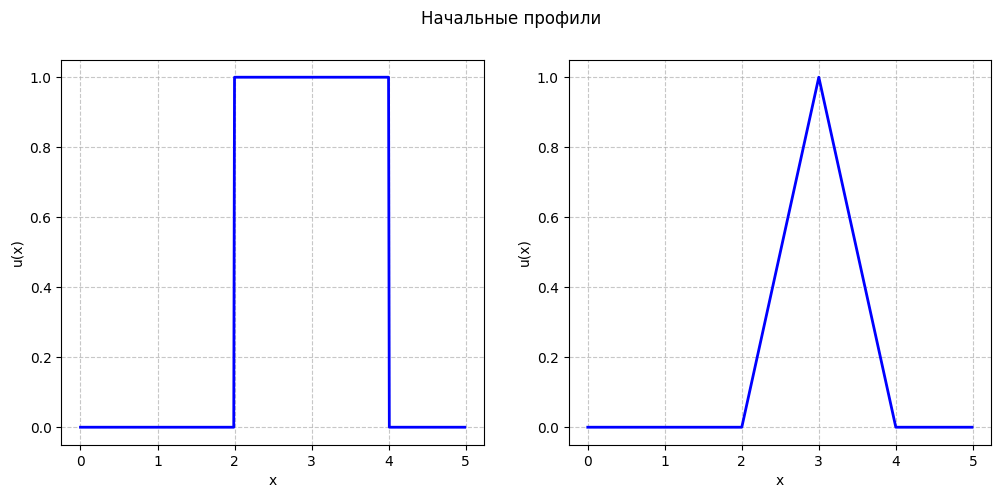

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

# Прямоугольник
def rectangle(x, height, L):
    if (L/2 <= x and x <= L):
        return height
    else:
        return 0

# Треугольник
def triangle(x, height, L):
    if (L/ 2 <= x and x <= 3*L/4):
        return x * height * 4/L - 2*height
    if(3*L/4 <= x and x <= L):
        return -x * height * 4/L + 4*height
    else:
        return 0

# Функция для построения графиков
def plot_start_profiles(x, y1, y2, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.plot(x, y1, color='blue', linewidth=2)
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.set_xlabel("x")
    ax1.set_ylabel("u(x)")
    

    ax2.plot(x, y2, color='blue', linewidth=2)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_xlabel("x")
    ax2.set_ylabel("u(x)")

    fig.suptitle(title)

    plt.show()

# Создание данных для начальных профилей
def start_profiles():
    x = np.arange(0, 5, 0.01)
    height = 1
    L = 4
    y_rect = []
    for i in x:
        y_rect.append(rectangle(i, height, L))
    y_triang = []
    for i in x:
        y_triang.append(triangle(i, height, L))
    
    return x, y_rect, y_triang

x, y_rect, y_triang = start_profiles()
plot_start_profiles(x, y_rect, y_triang, "Начальные профили")

# 2. Исследование прямоугольного профиля

### 2.1 Cхема Лакса

Схема Лакса имеет следующий шаблон:

![](images/lax_template.png)

Разностное уравнение, соответствующее недивергентному уравнению переноса:
$$\frac{u^{n+1}_{m} - 0.5\left( u^{n}_{m+1} + u^{n}_{m-1}\right)}{\tau} + u^{n}_{m} \frac{u^n_{m+1} - u^n_{m-1}}{2h} = 0$$

Разностное уравнение, соответствующее дивергентному уравнению переноса:
$$\frac{u^{n+1}_{m} - 0.5\left( u^{n}_{m+1} + u^{n}_{m-1}\right)}{\tau} + \frac{\left( u^n_{m+1} \right)^2 - \left(u^n_{m-1}\right)^2}{2 \cdot 2h} = 0$$

Порядок аппроксимации: $ O\left( \tau + h^2 + \frac{h^2}{\tau}\right)$

Схема является условно устойчивой: $$ \frac{\tau}{h} \cdot \max_{m}|u^{n}_{m}| \le 1 $$

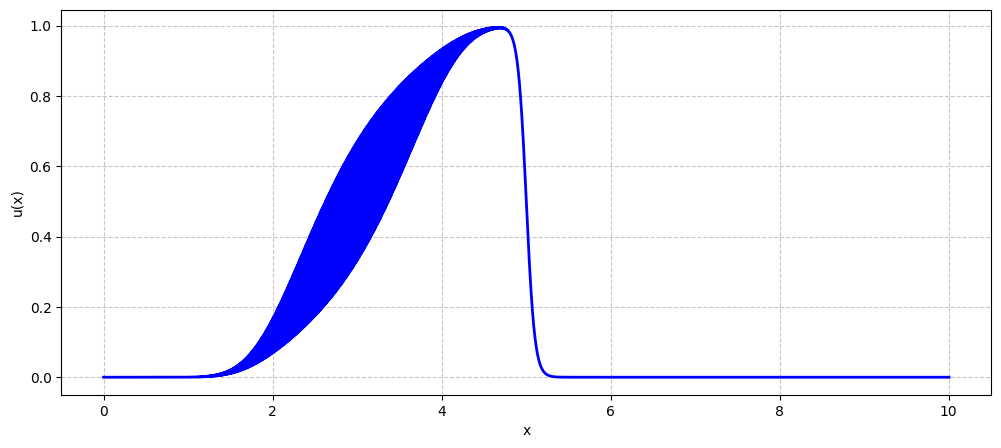

In [41]:
x_start = 0
x_end = 10
t_start = 0
t_end = 2
h = 0.005

height = 1
L = 4

def Lax_ndivergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start
    CFL = 0.1
    u_max = max(abs(elem) for elem in u)
    tau =  CFL * h / u_max
    while t_cur < t_end:
        if (tau * u_max / h > 1): 
            # Определяем шаг по времени tau на основе условия Куранта
            u_max = max(abs(elem) for elem in u)
            tau = CFL * h / u_max

        for i in range(1, len(x) - 1):
            u_new[i] = 0.5 * (u[i+1] + u[i-1]) - (tau / (2 * h)) * u[i] * (u[i+1] - u[i-1])

        # Периодические граничные условия
        u_new[0] = u_new[-2]
        u_new[-1] = u_new[1]
        t_cur += tau
        u = u_new.copy()
    return x, u

def plot_graph(x, y):
    plt.figure(figsize=(12, 5))
    plt.plot(x, y, color='blue', linewidth=2)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlabel("x")
    plt.ylabel("u(x)")
    
    plt.show()

x_Lax_ndivergent, u_Lax_ndivergent = Lax_ndivergent(rectangle, x_start, x_end, t_start, t_end, h)

plot_graph(x_Lax_ndivergent, u_Lax_ndivergent)

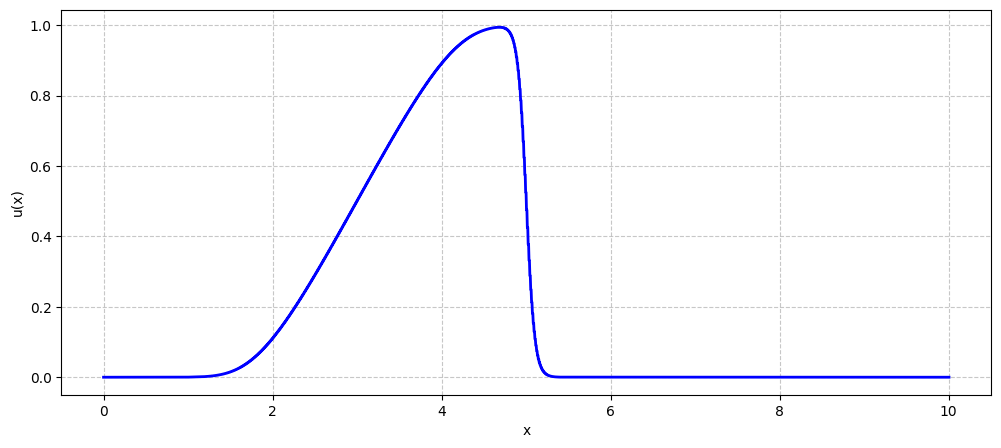

In [42]:
def Lax_divergent(u_0, x_start, x_end, t_start, t_end, h):
    x = np.arange(x_start, x_end + h, h)
    u = []
    for i in x:
        u.append(u_0(i, height, L))

    u_new = u.copy()
    t_cur = t_start

    while t_cur < t_end:
        # Определяем шаг по времени tau на основе условия Куранта
        CFL = 0.1
        u_max = np.max(np.abs(u))
        tau = CFL * h / u_max
        for i in range(1, len(x) - 1):
            u_new[i] = 0.5 * (u[i+1] + u[i-1]) - (tau / (4 * h)) * ((u[i+1])**2 - (u[i-1])**2)

        # Периодические граничные условия
        u_new[0] = u_new[-2]
        u_new[-1] = u_new[1]
        t_cur += tau
        u = u_new.copy()

    return x, u

x_Lax_divergent, u_Lax_divergent = Lax_divergent(rectangle, x_start, x_end, t_start, t_end, h)

plot_graph(x_Lax_divergent, u_Lax_divergent)